In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import pandas as pd

In [2]:
import sklearn

In [3]:
cols = ['class','age','menopause','tumor-size',
        'inv-nodes','node-caps','deg-malig',
        'breast','breast-quad','irradiat']

df = pd.read_csv('./datasets/breast-cancer.data',names = cols)

In [4]:
for this_col in cols[1:]:
    df[this_col] = df[this_col].astype('category')

In [5]:
map_dicts_list = []

for col in df.columns:
    labels = np.unique(df[col])
    #print(labels)
    map_dicts_list.append(dict([[val,i] for i,val in enumerate(labels)]))
    
map_dicts_v2 = dict([[att,this_dict] for att,this_dict in zip(df.columns,map_dicts_list)])

In [6]:
map_dicts_v2

{'class': {'no-recurrence-events': 0, 'recurrence-events': 1},
 'age': {'20-29': 0,
  '30-39': 1,
  '40-49': 2,
  '50-59': 3,
  '60-69': 4,
  '70-79': 5},
 'menopause': {'ge40': 0, 'lt40': 1, 'premeno': 2},
 'tumor-size': {'0-4': 0,
  '10-14': 1,
  '15-19': 2,
  '20-24': 3,
  '25-29': 4,
  '30-34': 5,
  '35-39': 6,
  '40-44': 7,
  '45-49': 8,
  '5-9': 9,
  '50-54': 10},
 'inv-nodes': {'0-2': 0,
  '12-14': 1,
  '15-17': 2,
  '24-26': 3,
  '3-5': 4,
  '6-8': 5,
  '9-11': 6},
 'node-caps': {'?': 0, 'no': 1, 'yes': 2},
 'deg-malig': {1: 0, 2: 1, 3: 2},
 'breast': {'left': 0, 'right': 1},
 'breast-quad': {'?': 0,
  'central': 1,
  'left_low': 2,
  'left_up': 3,
  'right_low': 4,
  'right_up': 5},
 'irradiat': {'no': 0, 'yes': 1}}

In [7]:
print('Instance of first class:', np.sum(df['class'] == 'no-recurrence-events'))
print('Instance of second class:', np.sum(df['class'] == 'recurrence-events'))

Instance of first class: 201
Instance of second class: 85


In [8]:
df_oc = df[df['class'] == 'no-recurrence-events']
df_oc = df_oc.drop('class',axis = 1)

In [9]:
#num_columns = df_oc._get_numeric_data().columns

Make an anomalies testing set

In [10]:
df_anom = df[df['class'] == 'recurrence-events']
df_anom = df_anom.drop('class',axis = 1)

In [11]:
num_columns = df_anom._get_numeric_data().columns

In [12]:
for this_col in num_columns:
    df_anom[this_col] = df_anom[this_col].astype('category')

Make OH versions

In [13]:
df_oh = pd.get_dummies(df,columns = cols[1:])

In [14]:
oh_cols = df_oh.columns[1:]

In [15]:
df_oc_oh = df_oh[df_oh['class'] == 'no-recurrence-events']
df_oc_oh = df_oc_oh.drop('class',axis = 1)

In [16]:
df_anom_oh = df_oh[df_oh['class'] == 'recurrence-events']
df_anom_oh = df_anom_oh.drop('class',axis = 1)

Create dictionary that maps inputs to their categorical index

### Train Trees

In [17]:
clfs = []
xs = []
ys = []
for col in cols[1:]:
    
    this_X = df_oc_oh.loc[:,[f for f in df_oc_oh.columns if not f.startswith(col)]]
    
    this_y = df_oc.loc[:,col]
    
    
    #this_X = df_oc.drop(col,axis = 1)
    #this_X = pd.get_dummies(this_X,)
    
    xs.append(this_X)
    ys.append(this_y)
    
    this_clf = tree.DecisionTreeClassifier()
    this_clf.fit(this_X,this_y)
    clfs.append(this_clf)

In [18]:
#plt.figure(figsize = (15,15))
#my_tree = tree.plot_tree(clfs[0])

### Get initial weights

In [19]:
from sklearn.metrics import recall_score, roc_auc_score

Initial weights for layer 1

In [66]:
recall_pc = []
w_2 = []

for i,clf in enumerate(clfs):
    recall_pc.append(recall_score(ys[i],clf.predict(xs[i]),average=None))
    w_2.append(clf.score(xs[i],ys[i]))
#in__weights_l1 = [f for g in recall_pc for f in g]
w_2 = np.array(w_2)

In [67]:
recall_pc

[array([1.        , 0.95238095, 0.93650794, 0.92957746, 0.85      ,
        0.8       ]),
 array([0.9893617 , 1.        , 0.97058824]),
 array([0.85714286, 0.85185185, 0.86956522, 0.85294118, 0.66666667,
        0.65714286, 0.66666667, 0.625     , 0.5       , 0.5       ,
        0.2       ]),
 array([1.        , 1.        , 0.66666667, 0.84210526, 1.        ,
        1.        ]),
 array([1.  , 1.  , 0.96]),
 array([0.96610169, 0.93137255, 0.85      ]),
 array([0.95145631, 0.76530612]),
 array([1.        , 0.93333333, 0.81690141, 0.77777778, 0.6       ]),
 array([1.        , 0.91891892])]

In [68]:
w_2

array([0.91542289, 0.9800995 , 0.73134328, 0.9800995 , 0.99502488,
       0.92537313, 0.86069652, 0.85074627, 0.98507463])

### Evaluate on Dataset

In [22]:
def neuron_l1(x_prime,weights,indx):
    
    x_wrong = np.delete(x_prime,indx,1)
    w_wrong = np.delete(weights,indx)
    
    return x_prime[:,indx]*weights[indx] - np.mean(x_wrong*w_wrong)

In [23]:
def neuron_l1_v2(x_prime,weights,indxs):
    
    my_res = np.zeros((len(x_prime)))

    for i,this_x_prime in enumerate(x_prime):
        
        if indxs[i] >= len(weights):
            indxs[i] -= 1
        this_x_wrong = np.delete(this_x_prime,indxs[i])
        w_wrong = np.delete(weights,indxs[i])
        my_res[i] = this_x_prime[indxs[i]]*weights[indxs[i]]-np.mean(this_x_wrong*w_wrong)
        
    return my_res

In [24]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

Encoder on normal data

In [25]:
dt_y_hat = []

for i, clf in enumerate(clfs):
    dt_y_hat.append(clf.predict_proba(xs[i]))

In [26]:
hl1 = np.zeros((len(df_oc),len(cols[1:])))

for i, x_prime in enumerate(dt_y_hat):
    
    label = cols[1:][i]
    dom_ind = [map_dicts_v2[label][f] for f in ys[i]]
    
    hl1[:,i] = neuron_l1_v2(x_prime,recall_pc[i],dom_ind)

Decoder

In [27]:
y_hat_normal = sigmoid(np.dot(hl1,w_2))

In [28]:
np.mean(y_hat_normal)

0.9965797587767958

Encoder on anomaly data

In [29]:
xs_anom = []
ys_anom = []

for col in cols[1:]:
    
    this_X = df_anom_oh.loc[:,[f for f in df_anom_oh.columns if not f.startswith(col)]]
    this_y = df_anom.loc[:,col]
    
    xs_anom.append(this_X)
    ys_anom.append(this_y)

In [30]:
dt_y_hat_anom = []

for i, clf in enumerate(clfs):
    dt_y_hat_anom.append(clf.predict_proba(xs_anom[i]))

In [31]:
hl1_anom = np.zeros((len(df_anom),len(cols[1:])))

for i, x_prime in enumerate(dt_y_hat_anom):
    
    label = cols[1:][i]
    dom_ind = [map_dicts_v2[label][f] for f in ys_anom[i]]
    hl1_anom[:,i] = neuron_l1_v2(x_prime,recall_pc[i],dom_ind)

Decoder

In [32]:
y_hat_anom = sigmoid(np.dot(hl1_anom,w_2))

In [33]:
np.mean(y_hat_anom)

0.7058542541844975

### Final Layer Optimizer

In [34]:
def get_cross_entropy_loss(y,y_hat):
    return(-y*np.log(y_hat)-(1-y)*np.log(1-y_hat))

In [35]:
y_normal = np.ones(len(y_hat_normal))

loss_normal = get_cross_entropy_loss(y_normal,y_hat_normal)
print(np.mean(loss_normal))

0.003431812464720235


In [36]:
y_anom = np.zeros(len(y_hat_anom))

loss_anom = get_cross_entropy_loss(y_anom,y_hat_anom)
print(np.mean(loss_anom))

2.2079696982581787


In [37]:
grad_w_2 = np.dot((-y_anom+y_hat_anom),hl1_anom)

In [38]:
hl1_anom.shape

(85, 9)

In [39]:
new_w_2 = w_2 - 0.1*grad_w_2

In [40]:
y_hat_anom_2 = sigmoid(np.dot(hl1_anom,new_w_2))

In [41]:
np.mean(get_cross_entropy_loss(y_anom,y_hat_anom_2))

0.5724348727340058

In [42]:
y_hat_normal_2 = sigmoid(np.dot(hl1,new_w_2))

In [43]:
np.mean(get_cross_entropy_loss(y_normal,y_hat_normal_2))

8.88049045477345

### Test

In [44]:
from copy import copy

In [45]:
test_weights = copy(w_2)

In [46]:
df_oh_x = df_oh.drop('class',axis = 1)

In [47]:
y_all = 1 - np.array([map_dicts_v2['class'][f] for f in df_oh['class']])

In [48]:
xs_test = []
ys_test = []

for col in cols[1:]:
    
    this_X = df_oh_x.loc[:,[f for f in df_oh_x.columns if not f.startswith(col)]]
    this_y = df.loc[:,col]
    
    xs_test.append(this_X)
    ys_test.append(this_y)

In [49]:
dt_y_hat_all = []

for i, clf in enumerate(clfs):
    dt_y_hat_all.append(clf.predict_proba(xs_test[i]))

In [50]:
hl1_all = np.zeros((len(df_oh_x),len(cols[1:])))

for i, x_prime in enumerate(dt_y_hat_all):
    
    label = cols[1:][i]
    dom_ind = [map_dicts_v2[label][f] for f in ys_test[i]]
    hl1_all[:,i] = neuron_l1_v2(x_prime,recall_pc[i],dom_ind)

Train final weights

In [75]:
w2 = np.copy(w_2)
lr = 0.001
iterations = 200

losses = []
accs = []

for i in range(iterations):
    
    this_y_hat = sigmoid(np.dot(hl1_all,w2))
    
    grad_w2 = np.dot((-y_all+this_y_hat),hl1_all)
    w2 = w2 - lr*grad_w2
    
    this_loss = np.mean(get_cross_entropy_loss(y_all,this_y_hat))
    this_acc = np.mean(y_all==(this_y_hat>=0.5))
    
    losses.append(this_loss)
    accs.append(this_acc)
    
    
    
    if i % 10 == 0 or i == iterations-1:
        print('Iteration {}: Loss = {:0.2f} / Acc: {:0.2f}'.format(i+1,this_loss,this_acc))
        
    

Iteration 1: Loss = 0.66 / Acc: 0.78
Iteration 11: Loss = 0.50 / Acc: 0.79
Iteration 21: Loss = 0.40 / Acc: 0.83
Iteration 31: Loss = 0.36 / Acc: 0.86
Iteration 41: Loss = 0.34 / Acc: 0.86
Iteration 51: Loss = 0.34 / Acc: 0.87
Iteration 61: Loss = 0.33 / Acc: 0.88
Iteration 71: Loss = 0.33 / Acc: 0.88
Iteration 81: Loss = 0.33 / Acc: 0.88
Iteration 91: Loss = 0.33 / Acc: 0.88
Iteration 101: Loss = 0.32 / Acc: 0.89
Iteration 111: Loss = 0.32 / Acc: 0.89
Iteration 121: Loss = 0.32 / Acc: 0.89
Iteration 131: Loss = 0.32 / Acc: 0.89
Iteration 141: Loss = 0.32 / Acc: 0.90
Iteration 151: Loss = 0.32 / Acc: 0.90
Iteration 161: Loss = 0.32 / Acc: 0.90
Iteration 171: Loss = 0.32 / Acc: 0.90
Iteration 181: Loss = 0.32 / Acc: 0.90
Iteration 191: Loss = 0.32 / Acc: 0.90
Iteration 200: Loss = 0.32 / Acc: 0.90


Text(0.5, 1.0, 'Change in Accuracy')

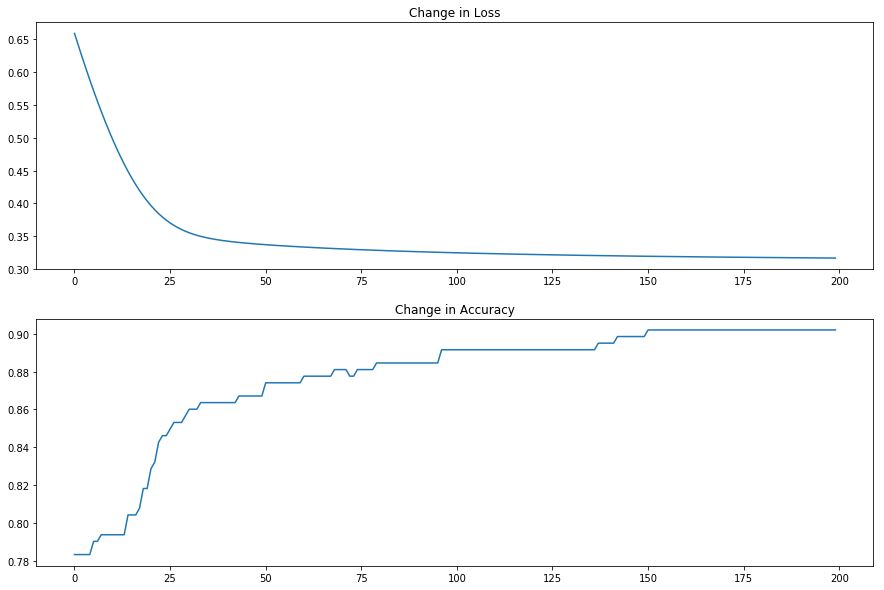

In [76]:
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(losses)
plt.title('Change in Loss')
plt.subplot(2,1,2)
plt.plot(accs)
plt.title('Change in Accuracy')

Train all weights

In [77]:
from copy import deepcopy

In [82]:
w1 = deepcopy(recall_pc)
w2 = deepcopy(w_2)

lr = 0.001
iterations = 200
lrw1 = 0.01


losses = []
accs = []

hl1_this = np.zeros((len(df_oh_x),len(cols[1:])))
    
for j,x_prime in enumerate(dt_y_hat_all):

    label = cols[1:][j]
    num_labels = [map_dicts_v2[label][f] for f in ys_test[j]]
    hl1_this[:,j] = neuron_l1_v2(x_prime,w1[j],num_labels)

this_y_hat = sigmoid(np.dot(hl1_this,w2))        

for i in range(iterations):
    
    hl1_this = np.zeros((len(df_oh_x),len(cols[1:])))
    
    for j,x_prime in enumerate(dt_y_hat_all):
        
        label = cols[1:][j]
        num_labels = [map_dicts_v2[label][f] for f in ys_test[j]]
        hl1_this[:,j] = neuron_l1_v2(x_prime,w1[j],num_labels)
        
        for k in np.unique(num_labels):
            
            indices = np.where(num_labels==k)
            this_probs = x_prime[indices]
            x_prime_this_this = x_prime[indices]
            y_hat_this_this = this_y_hat[indices]
            y_all_this_this = y_all[indices]
            
            grad_wj = np.dot((-y_all_this_this+y_hat_this_this)*w2[j],x_prime_this_this[:,k])
            grad_wl = np.dot((-y_all_this_this+y_hat_this_this)*w2[j],(-1/len(np.unique(num_labels)-1))*np.delete(x_prime_this_this,k,axis = 1))
    
            w1[j][k] = w1[j][k] - lrw1*grad_wj
            #print(k)
            #for this_indx in [f for f in np.unique(num_labels) if f != k]:
                #print('\t',this_indx)
                
                #if this_indx < k:
                    #grad_indx = this_indx
                #elif this_indx > k:
                    #grad_indx = this_indx-1
                #else:
                #    print('this should not have happened')
                #w1[j][this_indx] = w1[j][this_indx] - lrw1*grad_wl[grad_indx]
    #break
    this_y_hat = sigmoid(np.dot(hl1_this,w2))
    
    grad_w2 = np.dot((-y_all+this_y_hat),hl1_this)
    w2 = w2 - lr*grad_w2
    
    this_loss = np.mean(get_cross_entropy_loss(y_all,this_y_hat))
    this_acc = np.mean(y_all==(this_y_hat>=0.5))
    
    losses.append(this_loss)
    accs.append(this_acc)
    
    
    
    if i % 10 == 0 or i == iterations-1:
        print('Iteration {}: Loss = {:0.2f} / Acc: {:0.2f}'.format(i+1,this_loss,this_acc))
        
    

Iteration 1: Loss = 0.66 / Acc: 0.78
Iteration 11: Loss = 0.34 / Acc: 0.88
Iteration 21: Loss = 0.30 / Acc: 0.90
Iteration 31: Loss = 0.29 / Acc: 0.90
Iteration 41: Loss = 0.28 / Acc: 0.90
Iteration 51: Loss = 0.27 / Acc: 0.92
Iteration 61: Loss = 0.26 / Acc: 0.92
Iteration 71: Loss = 0.26 / Acc: 0.92
Iteration 81: Loss = 0.26 / Acc: 0.92
Iteration 91: Loss = 0.25 / Acc: 0.92
Iteration 101: Loss = 0.25 / Acc: 0.91
Iteration 111: Loss = 0.25 / Acc: 0.91
Iteration 121: Loss = 0.25 / Acc: 0.91
Iteration 131: Loss = 0.24 / Acc: 0.90
Iteration 141: Loss = 0.24 / Acc: 0.90
Iteration 151: Loss = 0.24 / Acc: 0.90
Iteration 161: Loss = 0.24 / Acc: 0.90
Iteration 171: Loss = 0.24 / Acc: 0.90
Iteration 181: Loss = 0.24 / Acc: 0.90
Iteration 191: Loss = 0.24 / Acc: 0.90
Iteration 200: Loss = 0.24 / Acc: 0.90


Text(0.5, 1.0, 'Change in Accuracy')

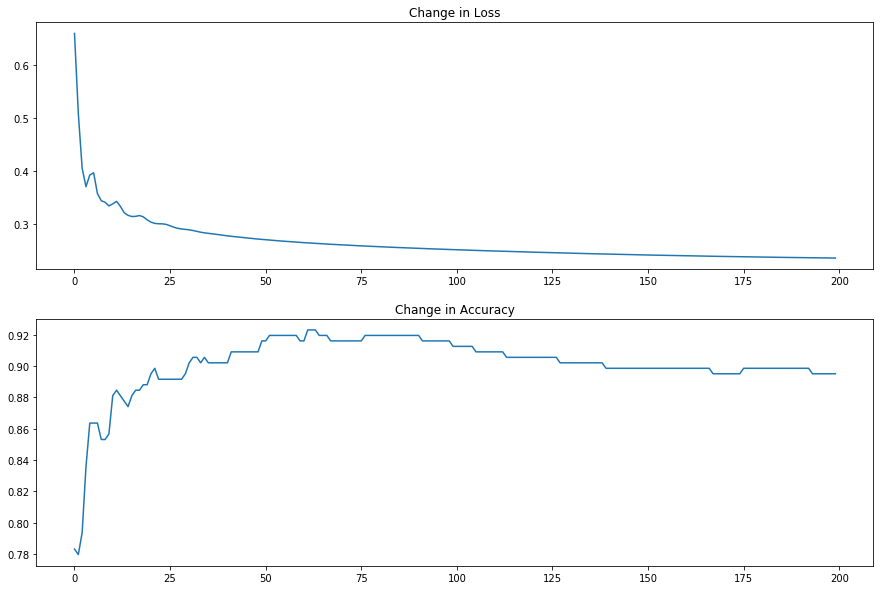

In [83]:
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
plt.plot(losses)
plt.title('Change in Loss')
plt.subplot(2,1,2)
plt.plot(accs)
plt.title('Change in Accuracy')